<a href="https://colab.research.google.com/github/ChrisW2420/FedDistill/blob/main/Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototype

## Import packages

In [1]:
!pip install -q tensorflow-model-optimization

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [3]:
!pip install --upgrade keras

In [4]:
import tensorflow as tf
import numpy as np
# for pruning
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import tf_keras as keras_model #only for pruning
from tf_keras import layers as model_layers
import keras
import tempfile
from tf_keras.callbacks import EarlyStopping, Callback
from keras import ops, layers
from tensorflow_docs.vis import embed # for GAN
import matplotlib.pyplot as plt

TODO: add wandb to all experiments

In [ ]:
!pip install wandb
import wandb
wandb.login()
from wandb.keras import WandbMetricsLogger

## Prepare Dataset

In [37]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
validation_split = 0.1

print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


## Models

In [6]:
def smallCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="smallcnn",
  )
  return model

def mediumCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return model

def bigCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="bigcnn",
  )
  return model

In [7]:
# early stopping when training converges on validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # only consider as improvement significant changes
    patience=2,      # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'        # 'min' because we want to minimize the loss
)

def trainCNN(model, _epoch, x_train = x_train, y_train = y_train):
  model.compile(
      optimizer='adam',
      loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
  )

  model.fit(x_train, y_train, batch_size=batch_size, epochs=_epoch,validation_split=validation_split, callbacks=[early_stopping])
  model.evaluate(x_test, y_test)

  return model

  # _, pretrained_weights = tempfile.mkstemp('.tf')

  # model.save_weights(pretrained_weights)

  # return pretrained_weights

#Pruning

error: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Sequential.


thus classifier models need to use tf_keras

### Basic implementation pf pruning

In [8]:
# functions
def prune_finetrain(base_model, _epochs, target_sparsity = 0.5, x_train = x_train, y_train = y_train):
  callbacks = [
      sparsity.UpdatePruningStep(),
      early_stopping
  ]
  steps_per_epoch = len(x_train)*(1-validation_split) // batch_size
  pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0, final_sparsity=target_sparsity,
                                              begin_step=0, end_step=int(steps_per_epoch*_epochs)) # increase sparsity

  model_for_pruning = sparsity.prune_low_magnitude(base_model) #default constant sparsity of 50%
  model_for_pruning.summary()

  model_for_pruning.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
  )

  model_for_pruning.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      validation_split=validation_split,
      callbacks=callbacks,
      epochs=_epochs,
  )

  return model_for_pruning

def get_model_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for weight in model.get_weights():
        total_weights += weight.size
        zero_weights += np.count_nonzero(weight == 0)
    return zero_weights / total_weights

def get_gzipped_model_size(model):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, keras_file = tempfile.mkstemp('.h5')
  model.save(keras_file, include_optimizer=False)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)

  return os.path.getsize(zipped_file)

In [ ]:
# training base model

model = mediumCNN()
model = trainCNN(model, 2)
_, pretrained_weights = tempfile.mkstemp('.tf')
model.save_weights(pretrained_weights)

# pruning
base_model = mediumCNN()
base_model.load_weights(pretrained_weights) # optional but recommended.
pruned_model = prune_finetrain(base_model, 5)

# continue training base model for performance comparison
base_model_copy = mediumCNN()
base_model_copy.load_weights(pretrained_weights)
base_model_copy = trainCNN(base_model_copy, 5)

Epoch 1/2
844/844 [==============================] - 29s 6ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.8798 - val_loss: 0.1127 - val_sparse_categorical_accuracy: 0.9643
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9754
Model: "mediumcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 8)         154       
 _3 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_re_lu_  (None, 14, 14, 8)         1         
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 8)         1         
 oling2d_2 (PruneLowMagnitu                                      
 de)                   

In [ ]:
pruned_model_stripped = sparsity.strip_pruning(pruned_model)
print("final model")
pruned_model.summary()

final model
Model: "mediumcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 8)         154       
 _3 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_re_lu_  (None, 14, 14, 8)         1         
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 8)         1         
 oling2d_2 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_conv2d  (None, 7, 7, 16)          2322      
 _4 (PruneLowMagnitude)                                          
                                             

In [ ]:
# compare accuracy, sparsity and file size
print(f"Base Model test accuracy: {base_model_copy.evaluate(x_test, y_test)[1]:.2f}%")
print(f"Pruned Model test accuracy: {pruned_model.evaluate(x_test, y_test)[1]:.2f}%")

sparsity_percentage = get_model_sparsity(base_model_copy) * 100
print(f"Base Model sparsity: {sparsity_percentage:.2f}%")

sparsity_percentage = get_model_sparsity(pruned_model) * 100
print(f"Pruned Model sparsity: {sparsity_percentage:.2f}%")

print('\n')
print("Size of gzipped base model: %.2f bytes" % (get_gzipped_model_size(base_model_copy)))
print("Size of gzipped pruned model: %.2f bytes" % (get_gzipped_model_size(pruned_model_stripped)))

313/313 [==============================] - 1s 3ms/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9836
Base Model test accuracy: 0.98%
313/313 [==============================] - 1s 4ms/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9813
Pruned Model test accuracy: 0.98%
Base Model sparsity: 0.00%
Pruned Model sparsity: 49.74%




/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Size of gzipped base model: 25706.00 bytes
Size of gzipped pruned model: 16939.00 bytes


## Pruning to as small as possible with > 99.5% accuracy as best

TODO: make this feature work:

either: target sparsity or target accuracy with max sparsity

early ending on convergence

In [ ]:
class CustomPolynomialDecay(sparsity.PolynomialDecay):
    def __init__(self, initial_sparsity, final_sparsity, begin_step, end_step, power=3, frequency=100):
        super().__init__(initial_sparsity, final_sparsity, begin_step, end_step, power=power, frequency=frequency)
        self.freeze_sparsity = False
        self.current_sparsity = 0

    # def _should_prune_in_step(self, step, begin_step, end_step, frequency):
    #     print('testing')
    #     if self.freeze_sparsity:
    #         print('freezed')
    #         return False
    #     else:
    #         return sparsity.PruningSchedule._should_prune_in_step(self, step, begin_step, end_step, frequency)

    def __call__(self, step):
        print('testing')
        if self.freeze_sparsity:
          return (False, self.current_sparsity)
        else:
          _, self.current_sparsity = super().__call__(step)
          return (_, self.current_sparsity)

    def freeze(self):
        self.freeze_sparsity = True

class FreezePruningOnAccuracyDrop(Callback):
    def __init__(self, pruning_schedule, threshold=0.96):
        super().__init__()
        self.pruning_schedule = pruning_schedule
        self.threshold = threshold

    def on_batch_end(self, batch, logs=None):
        current_accuracy = logs.get('sparse_categorical_accuracy')
        if current_accuracy < self.threshold:
            print(f"\nAccuracy has dropped below {self.threshold*100:.2f}%, freezing further pruning.")
            self.pruning_schedule.freeze()
            print(self.pruning_schedule.freeze_sparsity)

In [ ]:
# function
# save good performance ones
# class CustomEarlyStopping(Callback):
#     def on_batch_end(self, batch, logs=None):
#         current_accuracy = logs.get('sparse_categorical_accuracy')
#         if current_accuracy <= 0.975:
#             print(f"\nStopping training as accuracy has dropped to {current_accuracy*100:.2f}%")
#             self.model.stop_training = True

def prune_finetrain(base_model, _epochs):
  steps_per_epoch = len(x_train)*(1-validation_split) // batch_size
  print('steps_per_epoch: ', steps_per_epoch)
  # pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0.20, final_sparsity=0.70,
  #                                             begin_step=0, end_step=int(steps_per_epoch*_epochs)) # increase sparsity

  total_steps = int(_epochs * steps_per_epoch)
  pruning_schedule = CustomPolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.9,
    begin_step=batch_size,
    end_step=total_steps,
    power=3
  )

  model_for_pruning = sparsity.prune_low_magnitude(base_model, pruning_schedule=pruning_schedule)
  model_for_pruning.summary()


  callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir='/path/to/logs'),
    FreezePruningOnAccuracyDrop(pruning_schedule)
  ]


  model_for_pruning.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
  )

  model_for_pruning.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      validation_split=validation_split,
      callbacks=callbacks,
      epochs=_epochs,
  )

  return model_for_pruning

In [ ]:
# adaptive pruning
base_model = mediumCNN()
base_model.load_weights(pretrained_weights) # optional but recommended.
adaptive_pruned_model = prune_finetrain(base_model, 3)

steps_per_epoch:  843.0
Model: "mediumcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 8)         154       
 _48 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_re_lu_  (None, 14, 14, 8)         1         
 32 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 8)         1         
 oling2d_32 (PruneLowMagnit                                      
 ude)                                                            
                                                                 
 prune_low_magnitude_conv2d  (None, 7, 7, 16)          2322      
 _49 (PruneLowMagnitude)                                         
                                 

844/844 [==============================] - 12s 8ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.0855 - val_sparse_categorical_accuracy: 0.9732
Epoch 2/3
  1/844 [..............................] - ETA: 9s - loss: 0.0804 - sparse_categorical_accuracy: 0.9688
Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy has dropped below 96.00%, freezing further pruning.
True
221/844 [======>.......................] - ETA: 4s - loss: 0.1262 - sparse_categorical_accuracy: 0.9618
Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy has dropped below 96.00%, freezing further pruning.
True

Accuracy h

In [ ]:
# compare performance between adaptive pruning and basic pruning
print(f"adaptive Model test accuracy: {adaptive_pruned_model.evaluate(x_test, y_test)[1]:.2f}%")
print(f"pruned Model test accuracy: {pruned_model.evaluate(x_test, y_test)[1]:.2f}%")

sparsity_percentage = get_model_sparsity(adaptive_pruned_model) * 100
print(f"adaptive Model sparsity: {sparsity_percentage:.2f}%")

sparsity_percentage = get_model_sparsity(pruned_model) * 100
print(f"Pruned Model sparsity: {sparsity_percentage:.2f}%")

adaptive_pruned_model = sparsity.strip_pruning(adaptive_pruned_model)
print('\n')
print("Size of gzipped adaptive model: %.2f bytes" % (get_gzipped_model_size(adaptive_pruned_model)))
print("Size of gzipped pruned model: %.2f bytes" % (get_gzipped_model_size(pruned_model_stripped)))

313/313 [==============================] - 1s 2ms/step - loss: 0.2456 - sparse_categorical_accuracy: 0.9204
adaptive Model test accuracy: 0.92%
313/313 [==============================] - 1s 2ms/step - loss: 0.0584 - sparse_categorical_accuracy: 0.9807
pruned Model test accuracy: 0.98%
adaptive Model sparsity: 89.55%


Pruned Model sparsity: 49.74%




Size of gzipped adaptive model: 7417.00 bytes
Size of gzipped pruned model: 16924.00 bytes


# Prune + KD

## Knowledge Distillation functions

In [9]:
class Distiller(keras_model.Model):
    def __init__(self, teacher, student, alpha=0.1, temperature=3, **kwargs):
        super(Distiller, self).__init__(**kwargs)
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha, temperature, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=self.student_loss_fn)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of teacher with no gradient tracking
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of the student
            student_predictions = self.student(x, training=True)

            # Calculate the task-specific loss
            task_loss = self.student_loss_fn(y, student_predictions)

            # Calculate the soft targets and the distillation loss
            soft_targets = tf.nn.softmax(teacher_predictions / self.temperature)
            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(soft_targets, student_soft)

            # Calculate the total loss
            total_loss = (1 - self.alpha) * task_loss + self.alpha * distillation_loss * (self.temperature ** 2)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"task_loss": task_loss, "distillation_loss": distillation_loss, "total_loss": total_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of the student
        y_pred = self.student(x, training=False)

        # Calculate the task-specific loss
        task_loss = self.student_loss_fn(y, y_pred)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call_model(self):
      return self.student

def train_distill(_student, _teacher, _epoch, x_train = x_train, y_train=y_train, _alpha=0.1, _temp=3):
  distiller = Distiller(student=_student, teacher=_teacher)
  distiller.compile(
      optimizer=keras_model.optimizers.Adam(),
      metrics=[keras_model.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras_model.losses.KLDivergence(),
      alpha=_alpha,
      temperature=_temp,
  )

  # Distill teacher to student

  distiller.fit(x_train, y_train, epochs=_epoch, validation_split=validation_split)
  distiller.evaluate(x_test, y_test)

  return distiller

In [10]:
# simkd
class SimKDDistill(Distiller):
  def __init__(self, teacher, student,  alpha=0.1, temperature=3, **kwargs):
      super(SimKDDistill, self).__init__(teacher, student,**kwargs)

      # Assign weights and biases to the last layer, biases are always the same dimension as number of classes
      self.student.layers[-1].set_weights(self.teacher.layers[-1].get_weights())

      # Freeze the last layer (prevent it from updating)
      self.student.layers[-1].trainable = False

def train_simKD(_student, _teacher, _epoch, x_train = x_train, y_train=y_train, _alpha=0.1, _temp=3):
  distiller = SimKDDistill(student=_student, teacher=_teacher)
  distiller.compile(
      optimizer=keras_model.optimizers.Adam(),
      metrics=[keras_model.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras_model.losses.KLDivergence(),
      alpha=_alpha,
      temperature=_temp
  )

  distiller.fit(x_train, y_train, epochs=_epoch, validation_split=validation_split)
  distiller.evaluate(x_test, y_test)
  return distiller

## Implementation

first of all, we have 2 homogenous dataset and 2 models of the same architecture, they share the same testing dataset

In [11]:
# Data preparation
mid_point = len(x_train) // 2
# D1
x_train_1 = x_train[:mid_point]
y_train_1 = y_train[:mid_point]
x_train_2 = x_train[mid_point:]
y_train_2 = y_train[mid_point:]

# TODO: visualise distribution
def print_dist(y_train, name):
  unique, counts = np.unique(y_train, return_counts=True)
  label_distribution = dict(zip(unique, counts))

  # Print the label distribution
  print("Label Distribution in Training Set ", name, ":")
  for label, count in label_distribution.items():
      print(f"Label {label}: {count} instances")

print_dist(y_train_1, '1')
print_dist(y_train_2, '2')

Label Distribution in Training Set  1 :
Label 0: 2961 instances
Label 1: 3423 instances
Label 2: 2948 instances
Label 3: 3073 instances
Label 4: 2926 instances
Label 5: 2709 instances
Label 6: 2975 instances
Label 7: 3107 instances
Label 8: 2875 instances
Label 9: 3003 instances
Label Distribution in Training Set  2 :
Label 0: 2962 instances
Label 1: 3319 instances
Label 2: 3010 instances
Label 3: 3058 instances
Label 4: 2916 instances
Label 5: 2712 instances
Label 6: 2943 instances
Label 7: 3158 instances
Label 8: 2976 instances
Label 9: 2946 instances


We train model 1 on dataset 1

In [ ]:
model1 = mediumCNN()
model1 = trainCNN(model1, 5, x_train = x_train_1, y_train = y_train_1)

Epoch 1/5
422/422 [==============================] - 5s 6ms/step - loss: 0.5792 - sparse_categorical_accuracy: 0.8317 - val_loss: 0.1963 - val_sparse_categorical_accuracy: 0.9367
Epoch 2/5
422/422 [==============================] - 2s 6ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.1305 - val_sparse_categorical_accuracy: 0.9580
Epoch 3/5
422/422 [==============================] - 2s 5ms/step - loss: 0.1166 - sparse_categorical_accuracy: 0.9629 - val_loss: 0.1185 - val_sparse_categorical_accuracy: 0.9647
Epoch 4/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.0946 - val_sparse_categorical_accuracy: 0.9733
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0687 - sparse_categorical_accuracy: 0.9783


Prune Model1 to Model2 training on dataset 2. ie. model2 weights are initialised with model1 weights

In [ ]:
_, weights1 = tempfile.mkstemp('.tf')
model1.save_weights(weights1)

# pruning
model2 = mediumCNN()
model2.load_weights(weights1)
model2 = prune_finetrain(model2, 5, 0.6, x_train = x_train_2, y_train = y_train_2)
model2 = sparsity.strip_pruning(model2)

Model: "mediumcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 8)         154       
 _12 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_re_lu_  (None, 14, 14, 8)         1         
 8 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 8)         1         
 oling2d_8 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_conv2d  (None, 7, 7, 16)          2322      
 _13 (PruneLowMagnitude)                                         
                                                         

relay the knowledge learnt from dataset2 back to model1 with knowledge distillation: model2 is teacher, model1 is student

In [ ]:
model1_kd = mediumCNN()
model1_kd.load_weights(weights1)
model1_kd = train_distill(model1_kd, model2, 5, x_train = x_train_1, y_train=y_train_1)

Epoch 1/5
844/844 [==============================] - 8s 6ms/step - sparse_categorical_accuracy: 0.9765 - task_loss: 0.0748 - distillation_loss: 0.0195 - total_loss: 0.0849 - val_sparse_categorical_accuracy: 0.9750
Epoch 2/5
844/844 [==============================] - 5s 5ms/step - sparse_categorical_accuracy: 0.9798 - task_loss: 0.0662 - distillation_loss: 0.0157 - total_loss: 0.0738 - val_sparse_categorical_accuracy: 0.9790
Epoch 3/5
844/844 [==============================] - 5s 6ms/step - sparse_categorical_accuracy: 0.9814 - task_loss: 0.0588 - distillation_loss: 0.0149 - total_loss: 0.0663 - val_sparse_categorical_accuracy: 0.9750
Epoch 4/5
844/844 [==============================] - 5s 5ms/step - sparse_categorical_accuracy: 0.9840 - task_loss: 0.0552 - distillation_loss: 0.0150 - total_loss: 0.0632 - val_sparse_categorical_accuracy: 0.9797
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.9821


In [ ]:
model1_simkd = mediumCNN()
model1_simkd.load_weights(weights1)
model1_simkd = train_simKD(model1_simkd, model2, 5, x_train = x_train_1, y_train=y_train_1)


Epoch 1/5
844/844 [==============================] - 8s 7ms/step - sparse_categorical_accuracy: 0.9784 - task_loss: 0.0713 - distillation_loss: 0.0151 - total_loss: 0.0777 - val_sparse_categorical_accuracy: 0.9770
Epoch 2/5
844/844 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.9811 - task_loss: 0.0630 - distillation_loss: 0.0115 - total_loss: 0.0670 - val_sparse_categorical_accuracy: 0.9773
Epoch 3/5
844/844 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.9823 - task_loss: 0.0591 - distillation_loss: 0.0116 - total_loss: 0.0636 - val_sparse_categorical_accuracy: 0.9770
Epoch 4/5
844/844 [==============================] - 5s 6ms/step - sparse_categorical_accuracy: 0.9829 - task_loss: 0.0575 - distillation_loss: 0.0116 - total_loss: 0.0621 - val_sparse_categorical_accuracy: 0.9803
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.9820


In [ ]:
model1_plain = mediumCNN()
model1_plain.load_weights(weights1)
model1_plain = trainCNN(model1_plain, 5, x_train = x_train_1, y_train = y_train_1)

Epoch 1/5
422/422 [==============================] - 5s 8ms/step - loss: 0.0746 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.0776 - val_sparse_categorical_accuracy: 0.9767
Epoch 2/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0683 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9777
Epoch 3/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0625 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.0757 - val_sparse_categorical_accuracy: 0.9760
Epoch 4/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.0702 - val_sparse_categorical_accuracy: 0.9783
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0541 - sparse_categorical_accuracy: 0.9823


## Experiments
compare the performance of model1 after kd, simkd, raw training
- use heterogeneous datasets
- use different sized models

# Prune + KD + GAN

This prototype replaces the "public dataset" D1 with a GAN generated dataset

TODO:
1. build a MNIST Generating GAN model
2. use model2 $($classifier$)$ and D2 as input through GAN to generate a public dataset PD
3. connect model1 to PD instead of D1, repeat the KD step from model2 to model1

## basic cGAN implementation

copied from https://keras.io/examples/generative/conditional_gan/

with changes made according to https://github.com/soumith/ganhacks/tree/master:
- pooling

In [13]:
# constant and hyperparams
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

In [14]:
# create training set
def trainDataset(x_train, y_train):
  y_train = keras.utils.to_categorical(y_train, 10)
  # Create tf.data.Dataset.
  dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
  return dataset

In [15]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [16]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## demo GAN

In [ ]:
# training process
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

dataset = trainDataset(x_train, y_train)
cond_gan.fit(dataset, epochs=20)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - d_loss: 0.4613 - g_loss: 1.3758
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - d_loss: 0.5011 - g_loss: 1.2586
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - d_loss: 0.4280 - g_loss: 1.4827
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - d_loss: 0.2846 - g_loss: 1.9101
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - d_loss: 0.2071 - g_loss: 2.3749
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - d_loss: 0.6053 - g_loss: 1.0682
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - d_loss: 0.6367 - g_loss: 0.9151
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - d_loss: 0.6571 - g_loss: 0.8907
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - d_loss: 0.6689 - g_loss: 0.8258
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - d_loss: 0.6676 - g_loss: 0.8039
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - d_loss: 0.6727 - g_loss: 0.7868
Epoch 12/20
870/938 ━━━━━━━━━━

In [49]:
# generate image
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

num_interpolation = 1

# Sample noise for the interpolation.
def interpolate_class(target_number):
    # Sample noise for the interpolation.
    interpolation_noise = keras.random.normal(shape=(1, latent_dim))
    interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
    interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))
    # Convert the start and end labels to one-hot encoded vectors.
    target_label = keras.utils.to_categorical([target_number], num_classes)
    target_label = ops.cast(target_label, "float32")

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, target_label], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


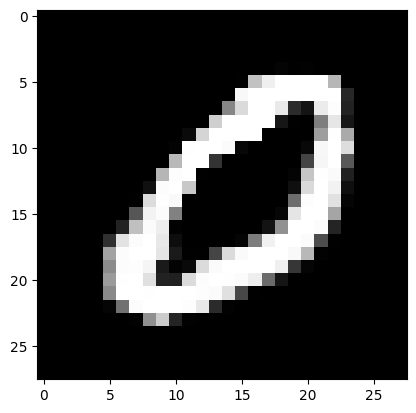

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


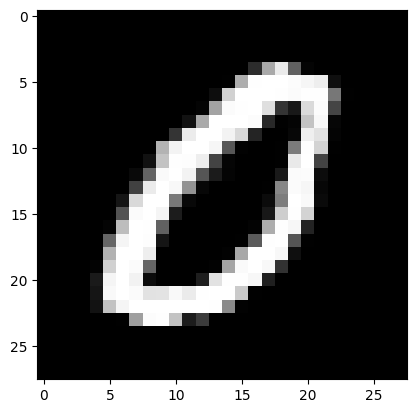

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


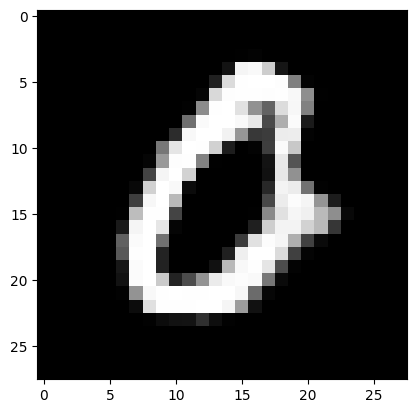

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


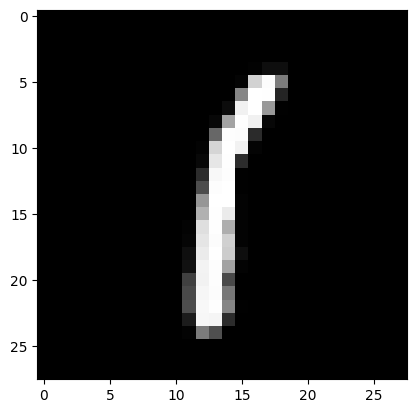

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


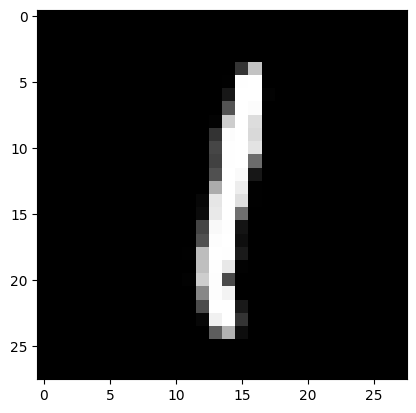

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


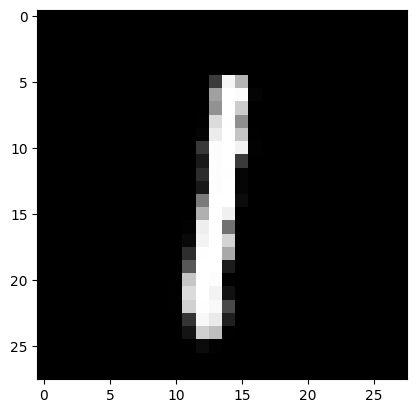

2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


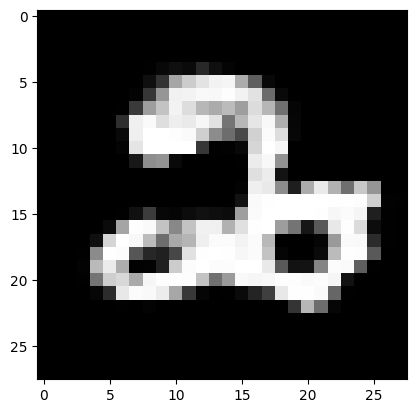

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


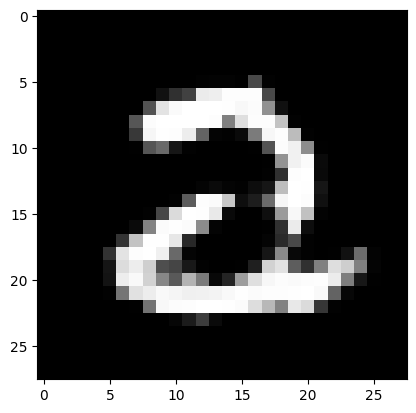

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


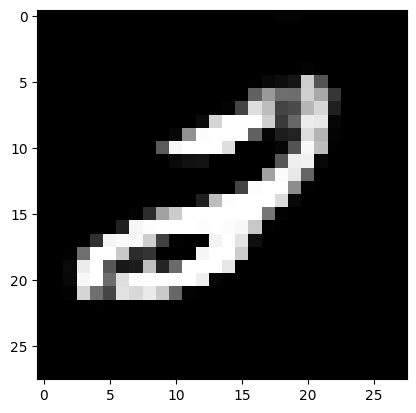

3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


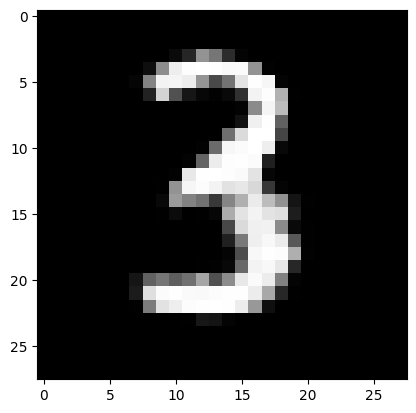

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


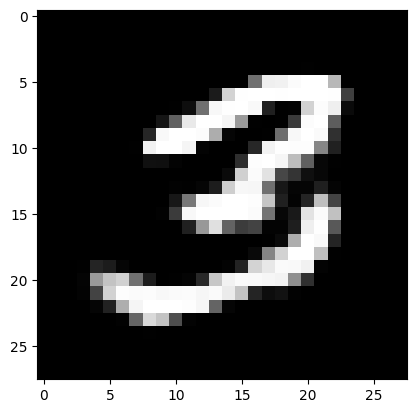

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


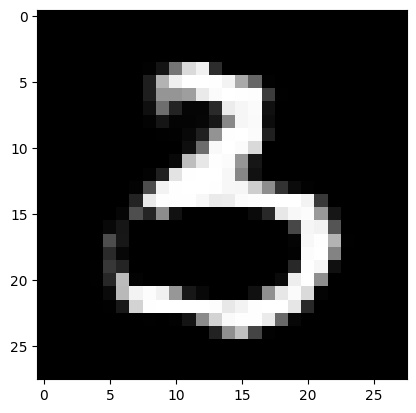

4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


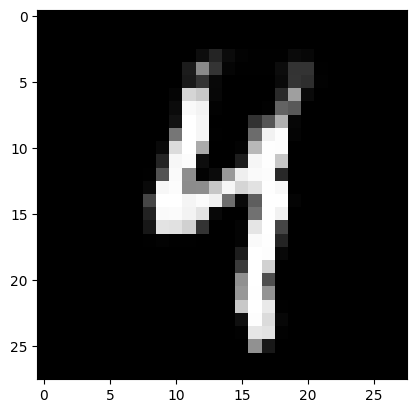

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


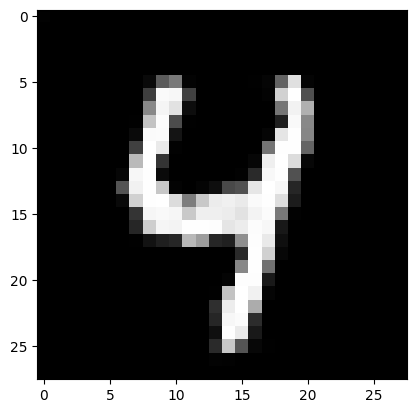

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


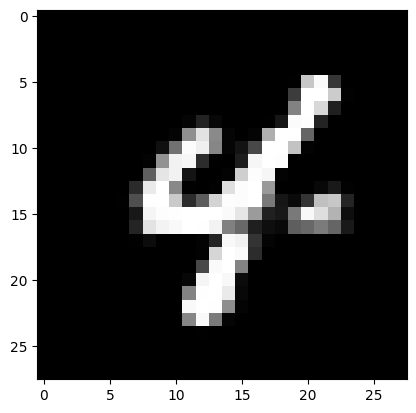

5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


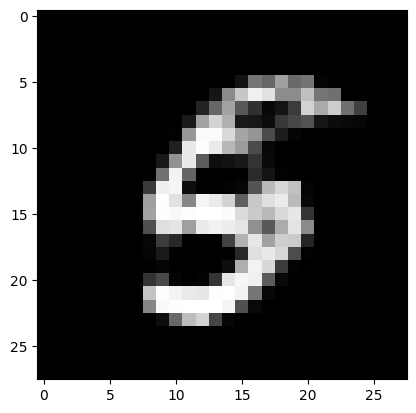

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


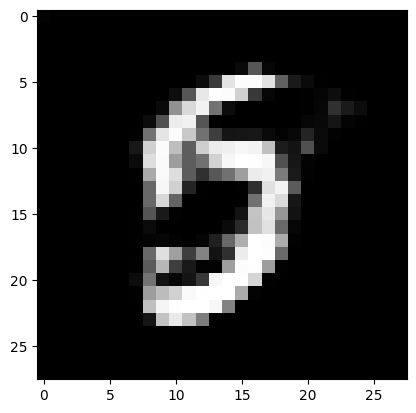

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


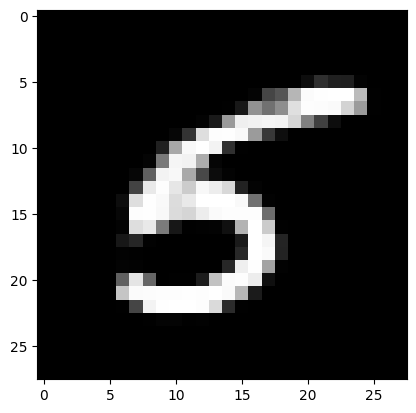

6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


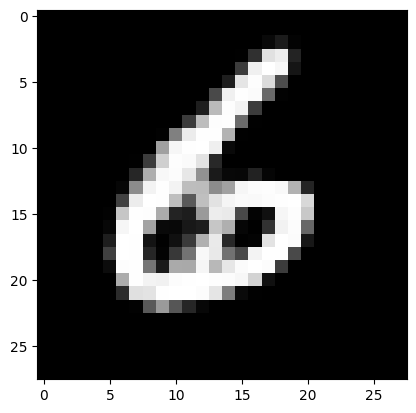

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


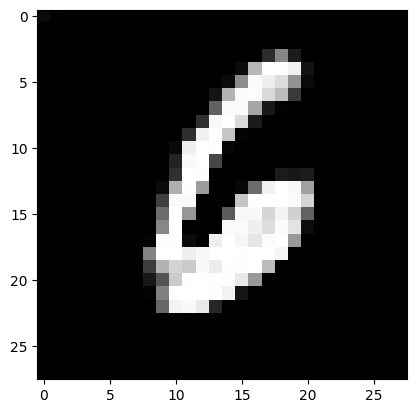

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


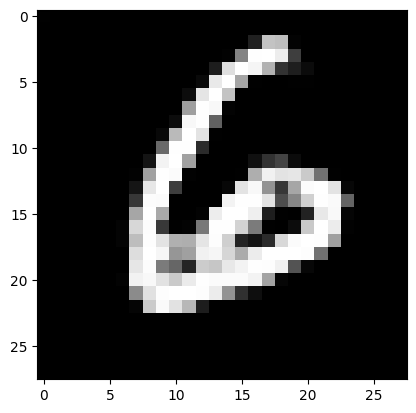

7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


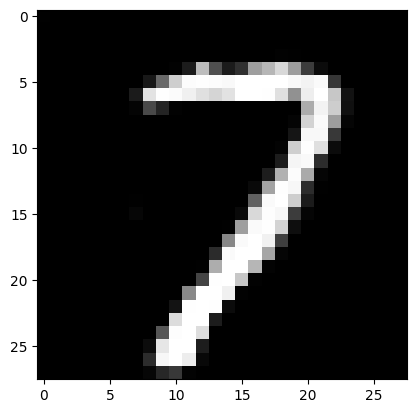

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


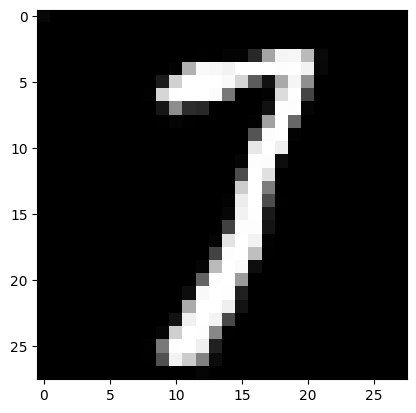

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


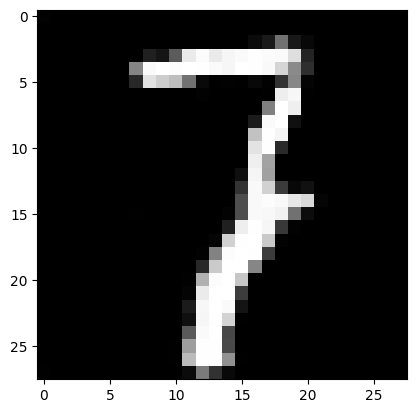

8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


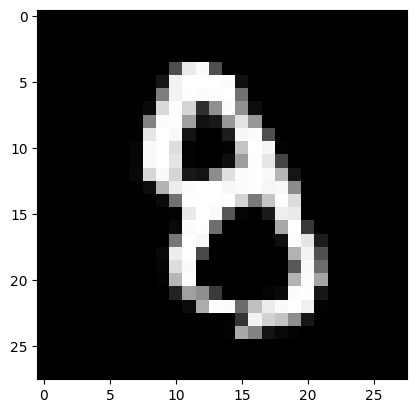

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


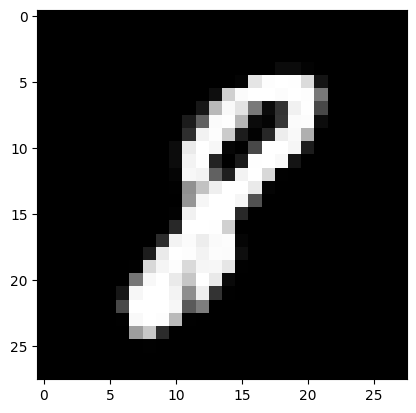

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


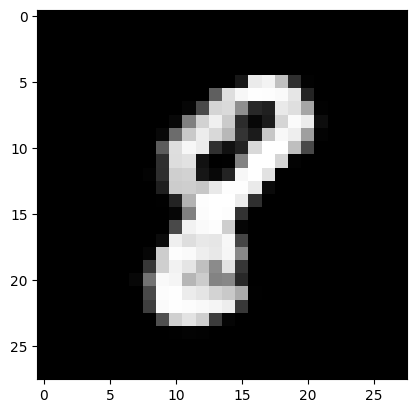

9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


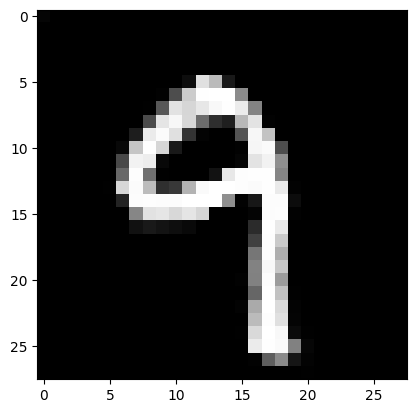

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


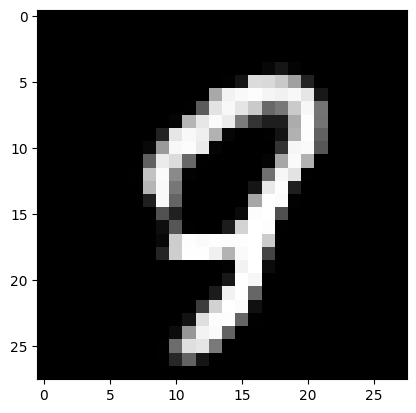

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


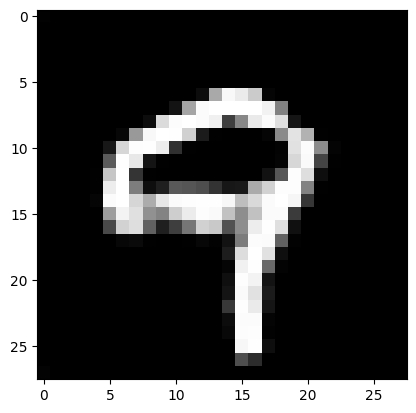

In [50]:
# generate images and visualise
for num in range(10):
  target_number = num
  print(num)
  for _ in range(3):
    generated_images = interpolate_class(target_number)
    generated_images *= 255.0
    converted_images = generated_images.astype(np.uint8)
    converted_images = ops.image.resize(converted_images, (28, 28)).numpy().astype(np.uint8)

    # Plot the first generated image
    plt.imshow(converted_images[0], cmap='gray')
    plt.show()

FID score and Inception Score:

Classifiers that achieve the best (lowest) FID score tend to have greater sample variety while classifiers achieving the best (highest) IS score tend to have better quality within individual images.

TODO: implement this at experimentation phase

## Implementation

model1 trains on private real data, mimicing the most capable client providing initialisation for the global models.

model1 -> global classifier

gen1 -> global generator

In [12]:
model1 = mediumCNN()
model1 = trainCNN(model1, 5, x_train = x_train_1, y_train = y_train_1)

Epoch 1/5
422/422 [==============================] - 43s 11ms/step - loss: 0.5715 - sparse_categorical_accuracy: 0.8237 - val_loss: 0.2208 - val_sparse_categorical_accuracy: 0.9360
Epoch 2/5
422/422 [==============================] - 4s 9ms/step - loss: 0.1752 - sparse_categorical_accuracy: 0.9458 - val_loss: 0.1635 - val_sparse_categorical_accuracy: 0.9423
Epoch 3/5
422/422 [==============================] - 4s 10ms/step - loss: 0.1322 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.1300 - val_sparse_categorical_accuracy: 0.9567
Epoch 4/5
422/422 [==============================] - 3s 6ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.1147 - val_sparse_categorical_accuracy: 0.9600
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9739


train generator on D1

In [54]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

dataset = trainDataset(x_train_1, y_train_1)
cond_gan.fit(dataset, epochs=20)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - d_loss: 0.1471 - g_loss: 2.8424
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.5694 - g_loss: 1.3582
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - d_loss: 0.5918 - g_loss: 1.1360
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - d_loss: 0.6154 - g_loss: 1.0960
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6426 - g_loss: 0.9881
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6545 - g_loss: 0.9161
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - d_loss: 0.6620 - g_loss: 0.9067
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - d_loss: 0.6547 - g_loss: 0.8814
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - d_loss: 0.6694 - g_loss: 0.8647
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - d_loss: 0.6682 - g_loss: 0.8561
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - d_loss: 0.6785 - g_loss: 0.8478
Epoch 12/20
469/469 ━━━━━━━━━━

prune the global classifier weights to client2

In [18]:
weights_file = 'model1.weights.h5'
model1.save_weights(weights_file)

# pruning
model2 = mediumCNN()
model2.load_weights(weights_file)
model2 = prune_finetrain(model2, 5, 0.6, x_train = x_train_2, y_train = y_train_2)
model2 = sparsity.strip_pruning(model2)

Model: "mediumcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 8)         154       
 _3 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_leaky_  (None, 14, 14, 8)         1         
 re_lu_2 (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 8)         1         
 oling2d_2 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_conv2d  (None, 7, 7, 16)          2322      
 _4 (PruneLowMagnitude)                                  

In [45]:
# generate pseudo dataset
trained_gen = cond_gan.generator

# Sample noise for the interpolation.
def interpolate_class(target_number):
    num_interpolation = 1
    # Sample noise for the interpolation.
    interpolation_noise = keras.random.normal(shape=(1, latent_dim))
    interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
    interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))
    # Convert the start and end labels to one-hot encoded vectors.
    target_label = keras.utils.to_categorical([target_number], num_classes)
    target_label = ops.cast(target_label, "float32")

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, target_label], 1)
    fake = trained_gen.predict(noise_and_labels,verbose = 0)
    return fake

def pseudoDataset(total_num):
  pseudo_images = []
  for num in range(10):
    target_number = num
    print('Generating', int(total_num/10), 'fake images of digit', num, '......')
    for _ in range(int(total_num/10)):
      generated_images = interpolate_class(target_number)
      generated_images *= 255.0
      converted_images = generated_images.astype(np.uint8)
      converted_images = ops.image.resize(converted_images, (28, 28)).numpy().astype(np.uint8)
      pseudo_images.append(converted_images)
  pseudo_images = np.concatenate(pseudo_images, axis=0)
  pseudo_labels = np.repeat(np.arange(10), int(total_num/10))
  return pseudo_images, pseudo_labels

# # Plot the first generated image
# plt.imshow(converted_images[0], cmap='gray')
# plt.show()

In [57]:
D_pseudo = pseudoDataset(1000)

Generating 100 fake images of digit 0 ......
Generating 100 fake images of digit 1 ......
Generating 100 fake images of digit 2 ......
Generating 100 fake images of digit 3 ......
Generating 100 fake images of digit 4 ......
Generating 100 fake images of digit 5 ......
Generating 100 fake images of digit 6 ......
Generating 100 fake images of digit 7 ......
Generating 100 fake images of digit 8 ......
Generating 100 fake images of digit 9 ......


In [60]:
model1_simkd = mediumCNN()
model1_simkd.load_weights(weights_file)
model1_simkd = train_simKD(model1_simkd, model2, 5, x_train = D_pseudo[0], y_train=D_pseudo[1])

Epoch 1/5
29/29 [==============================] - 3s 29ms/step - sparse_categorical_accuracy: 0.9689 - task_loss: 11.2298 - distillation_loss: 0.4508 - total_loss: 10.5126 - val_sparse_categorical_accuracy: 0.9100
Epoch 2/5
29/29 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.9833 - task_loss: 5.8359 - distillation_loss: 0.4781 - total_loss: 5.6826 - val_sparse_categorical_accuracy: 0.9200
Epoch 3/5
29/29 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.9844 - task_loss: 4.1144 - distillation_loss: 0.4521 - total_loss: 4.1099 - val_sparse_categorical_accuracy: 0.7700
Epoch 4/5
29/29 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.9856 - task_loss: 4.8576 - distillation_loss: 0.5207 - total_loss: 4.8405 - val_sparse_categorical_accuracy: 0.9600
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.9565


In [58]:
model1.evaluate(x_test, y_test)
model1.evaluate(D_pseudo[0], D_pseudo[1])

32/32 [==============================] - 0s 3ms/step - loss: 14.1400 - sparse_categorical_accuracy: 0.9650


[14.140047073364258, 0.9649999737739563]

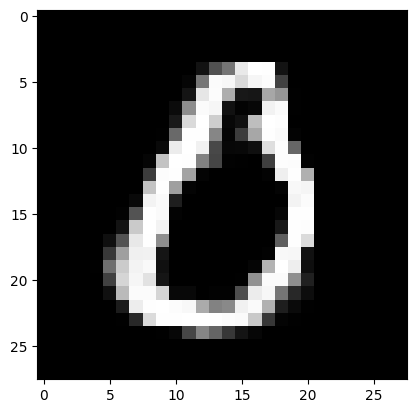

0


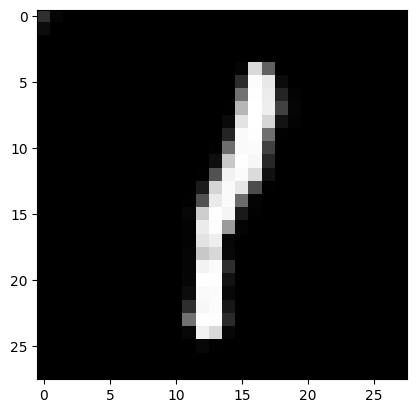

1


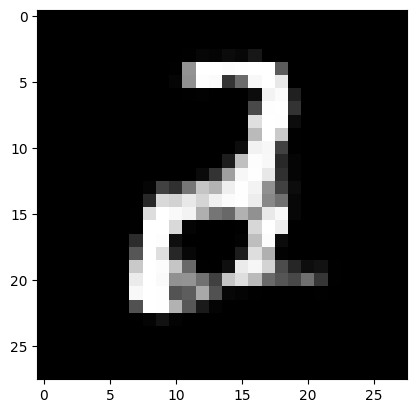

2


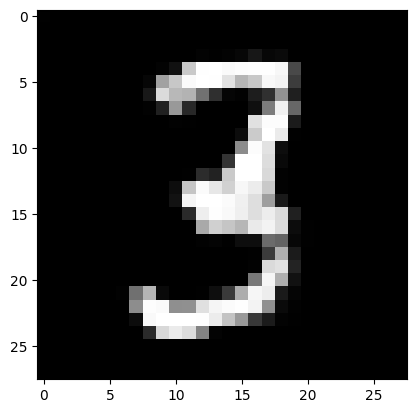

3


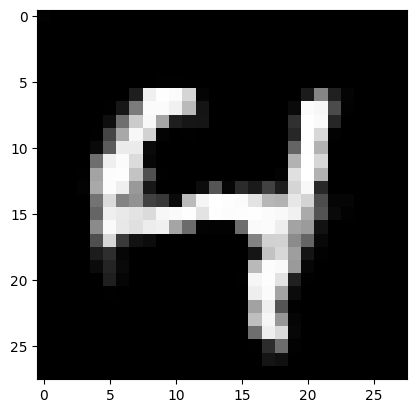

4


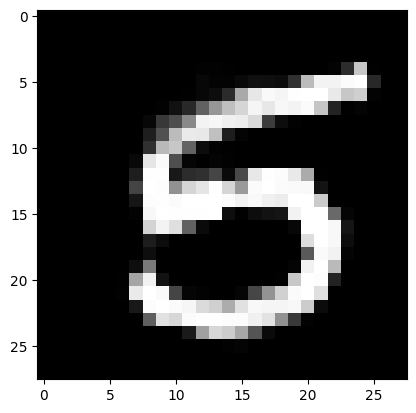

5


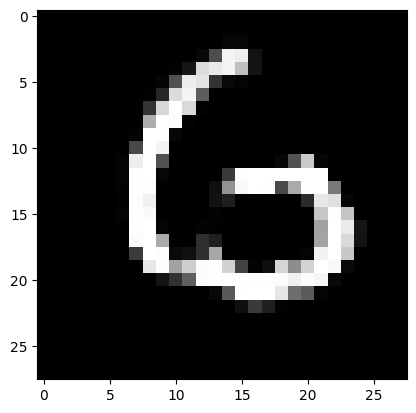

6


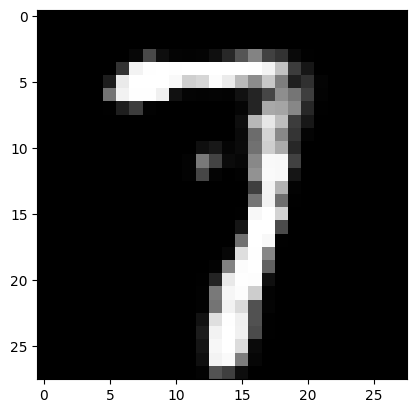

7


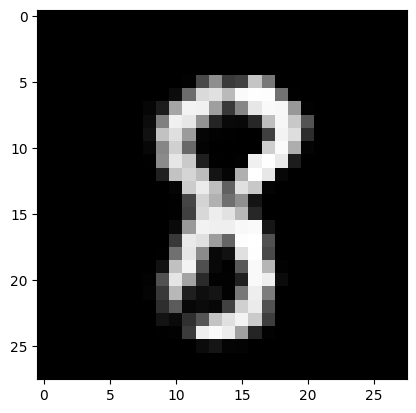

8


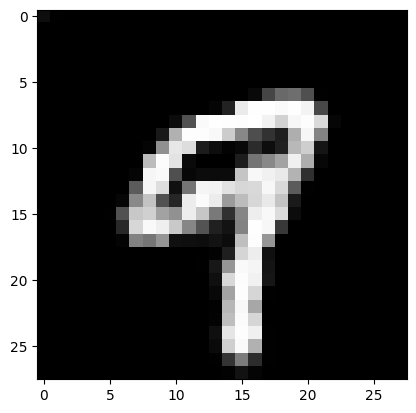

9


In [59]:
for idx in range(10):
  pos = idx*100+20
  img = D_pseudo[0][pos]
  label = D_pseudo[1][pos]
  plt.imshow(img, cmap='gray')
  plt.show()
  print(label)